In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from models.cmlp_container import CMLP_Container
import pickle
import seaborn as sns
import yaml

In [2]:
config = {
    "data_dir": "../data",
    "yaml_path": "../configs/train_cmlp.yaml",
    "model_save_dir": "./saved_models",
    "catagory": "endogenous",
}
cmlp_container = CMLP_Container(eval_config=config)

endogenous data loaded...


True variable usage = 6.56%
--------------------------------------------------
Threshold = True
Estimated variable usage = 11.44%
Accuracy = 90.00%
--------------------------------------------------
MAFE train: 0.0813
MAFE val: 0.0816
TPR: 0.6102
TNR: 0.9203
MAEE: 0.0123
--------------------------------------------------


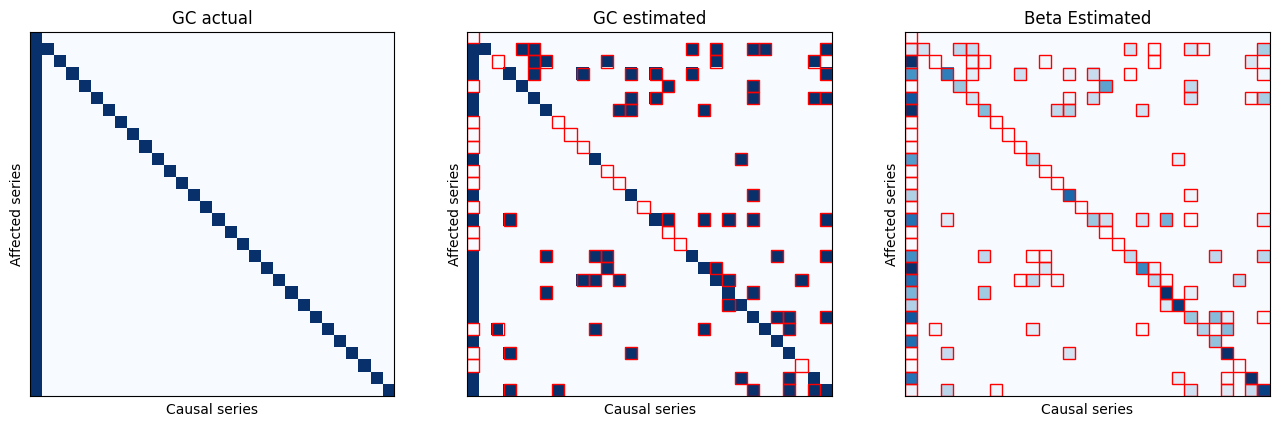

In [3]:
# Verify learned Granger causality
GC = cmlp_container.GC
GC_est = cmlp_container.cmlp.GC().cpu().data.numpy()
Beta_est = cmlp_container.cmlp.GC(threshold=False).cpu().data.numpy()

print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('-'*50)
print('Threshold = True')
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))
print('-'*50)
cmlp_container.evaluate()
print('-'*50)
# print(f'Threshold = False')
# print(f'Estimated variable usage = %.2f%%' % (100 * np.mean(Beta_est)))
# print(f'Accuracy = %.2f%%' % (100 * np.mean(GC == Beta_est)))

# Make figures
fig, axarr = plt.subplots(1, 3, figsize=(16, 10))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(GC_est), len(GC_est), 0))
axarr[1].set_title('GC estimated')
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

axarr[2].imshow(Beta_est, cmap='Blues', vmin=0, vmax=1, extent=(0, len(Beta_est), len(Beta_est), 0))
axarr[2].set_title(f'Beta Estimated')
axarr[2].set_ylabel('Affected series')
axarr[2].set_xlabel('Causal series')
axarr[2].set_xticks([])
axarr[2].set_yticks([])

# Mark disagreements
for i in range(len(GC_est)):
    for j in range(len(GC_est)):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

for i in range(len(Beta_est)):
    for j in range(len(Beta_est)):
        if GC[i, j] != Beta_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[2].add_patch(rect)
plt.show()

In [4]:
with open(f'{config["model_save_dir"]}/cmlp_{config["catagory"]}_loss.pickle', 'rb') as f:
    train_loss_list = pickle.load(f)
for i in range(len(train_loss_list)):
    train_loss_list[i] = train_loss_list[i].cpu().numpy()

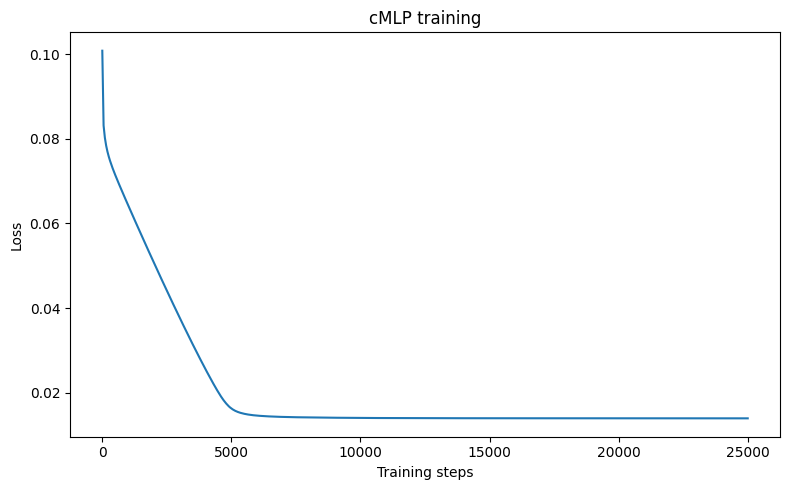

In [5]:
# Loss plot
plt.figure(figsize=(8, 5))
plt.plot(50 * np.arange(len(train_loss_list)), train_loss_list)
plt.title('cMLP training')
plt.ylabel('Loss')
plt.xlabel('Training steps')
plt.tight_layout()
plt.show()